In [1]:
import sqlite3
import pandas as pd
from sqlalchemy import create_engine, Table, MetaData
from sqlalchemy.orm import sessionmaker
from IPython.display import display
import matplotlib.pyplot as plt


engine = create_engine('sqlite:///database.sqlite')  

metadata = MetaData()

Session = sessionmaker(bind=engine)
session = Session()

Country_table = session.query(Table('Country', metadata, autoload_with=engine))
League_table = session.query(Table('League', metadata, autoload_with=engine))
Match_table = session.query(Table('Match', metadata, autoload_with=engine))
Player_table = session.query(Table('Player', metadata, autoload_with=engine))
Player_Attributes_table = session.query(Table('Player_Attributes', metadata, autoload_with=engine))
Team_table = session.query(Table('Team', metadata, autoload_with=engine))
Team_Attributes_table = session.query(Table('Team_Attributes', metadata, autoload_with=engine))

In [2]:
Country_df = pd.DataFrame(Country_table)
League_df = pd.DataFrame(League_table)
Match_df = pd.DataFrame(Match_table)
Player_df = pd.DataFrame(Player_table)
Player_Attributes_df = pd.DataFrame(Player_Attributes_table)
Team_df = pd.DataFrame(Team_table)
Team_Attributes_df = pd.DataFrame(Team_Attributes_table)

In [3]:
player_name = Player_df[['player_api_id','player_name']]
Team_name = Team_df[['team_api_id','team_long_name']]
League_name = League_df[['country_id','name']]

In [4]:
Player_df

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154
...,...,...,...,...,...,...,...
11055,11071,26357,Zoumana Camara,2488,1979-04-03 00:00:00,182.88,168
11056,11072,111182,Zsolt Laczko,164680,1986-12-18 00:00:00,182.88,176
11057,11073,36491,Zsolt Low,111191,1979-04-29 00:00:00,180.34,154
11058,11074,35506,Zurab Khizanishvili,47058,1981-10-06 00:00:00,185.42,172


In [5]:
import xml.etree.ElementTree as ET
card_table = Match_df.dropna(subset=['card']) 
card_table = card_table[card_table['card'].str.strip() != '<card />']  
card = card_table['card']

goal_table = Match_df.dropna(subset=['goal'])
goal = goal_table['goal']

possession_table = Match_df.dropna(subset=['possession'])  
possession = possession_table[possession_table['possession'].str.strip() != '<possession />']  

possession = possession['possession']








def parse_possession_data(xml_data):
    try:
        root = ET.fromstring(xml_data)  # Parse the XML data
    except ET.ParseError as e:
        print(f"Error parsing XML: {e}")
        return pd.DataFrame()  # Return empty DataFrame if parsing fails

    possession_data = []
    
    # Iterate over each 'value' entry under the 'possession' root
    for value in root.findall('value'):
        possession_info = {
            'Comment': value.find('comment').text if value.find('comment') is not None else None,
            'EventIncidentType': value.find('event_incident_typefk').text if value.find('event_incident_typefk') is not None else None,
            'ElapsedTime': value.find('elapsed').text if value.find('elapsed') is not None else None,
            'Subtype': value.find('subtype').text if value.find('subtype') is not None else None,
            'SortOrder': value.find('sortorder').text if value.find('sortorder') is not None else None,
            'AwayPos': value.find('awaypos').text if value.find('awaypos') is not None else None,
            'HomePos': value.find('homepos').text if value.find('homepos') is not None else None,
            'EventNumber': value.find('n').text if value.find('n') is not None else None,
            'Type': value.find('type').text if value.find('type') is not None else None,
            'ID': value.find('id').text if value.find('id') is not None else None,
        }
        possession_data.append(possession_info)
    
    df_possession = pd.DataFrame(possession_data)  # Create DataFrame from the extracted data
    return df_possession
    
def parse_goals_to_table(xml_data):
    root = ET.fromstring(xml_data)
    
    goal_data = []
    
    for value in root.findall('value'):
        goal_info = {}
        
        goal_info['comment'] = value.find('comment').text if value.find('comment') is not None else None
        goal_info['goals'] = value.find('stats/goals').text if value.find('stats/goals') is not None else None
        goal_info['shoton'] = value.find('stats/shoton').text if value.find('stats/shoton') is not None else None
        goal_info['event_incident_typefk'] = value.find('event_incident_typefk').text if value.find('event_incident_typefk') is not None else None
        goal_info['elapsed'] = value.find('elapsed').text if value.find('elapsed') is not None else None
        goal_info['player1'] = value.find('player1').text if value.find('player1') is not None else None
        goal_info['player2'] = value.find('player2').text if value.find('player2') is not None else None
        goal_info['subtype'] = value.find('subtype').text if value.find('subtype') is not None else None
        goal_info['sortorder'] = value.find('sortorder').text if value.find('sortorder') is not None else None
        goal_info['team'] = value.find('team').text if value.find('team') is not None else None
        goal_info['goal_id'] = value.find('id').text if value.find('id') is not None else None
        goal_info['goal_type'] = value.find('goal_type').text if value.find('goal_type') is not None else None
        goal_info['n'] = value.find('n').text if value.find('n') is not None else None
        goal_info['type'] = value.find('type').text if value.find('type') is not None else None
        
        if goal_info:
            goal_data.append(goal_info)
    df = pd.DataFrame(goal_data)
    return df
    
def parse_card_data(xml_data):
    try:
        root = ET.fromstring(xml_data) 
    except ET.ParseError as e:
        print(f"Error parsing XML: {e}")
        return pd.DataFrame()  

    cards_data = []
    
    for value in root.findall('value'):
        card_info = {
            'YCards': value.find('stats/ycards').text if value.find('stats/ycards') is not None else None,
            'EventIncidentType': value.find('event_incident_typefk').text if value.find('event_incident_typefk') is not None else None,
            'ElapsedTime': value.find('elapsed').text if value.find('elapsed') is not None else None,
            'CardType': value.find('card_type').text if value.find('card_type') is not None else None,
            'Subtype': value.find('subtype').text if value.find('subtype') is not None else None,
            'Player1': value.find('player1').text if value.find('player1') is not None else None,
            'SortOrder': value.find('sortorder').text if value.find('sortorder') is not None else None,
            'Team': value.find('team').text if value.find('team') is not None else None,
            'EventNumber': value.find('n').text if value.find('n') is not None else None,
            'Type': value.find('type').text if value.find('type') is not None else None,
            'ID': value.find('id').text if value.find('id') is not None else None,
            'Comment': value.find('comment').text if value.find('comment') is not None else None,
        }
        cards_data.append(card_info)
    
    df_cards = pd.DataFrame(cards_data)  # Create DataFrame from the extracted data
    return df_cards



In [6]:

all_cards_tables = []
all_goals_tables = []  
all_possession_tables = []

for i, s in enumerate(goal):
    df2 = parse_goals_to_table(s)
    df2['id_match'] = goal_table.index[i]  
    all_goals_tables.append(df2)  
final_goals_table = pd.concat(all_goals_tables, ignore_index=True)


for i, s in enumerate(card):
    df2 = parse_card_data(s)
    if not df2.empty:  
        df2['id_match'] = card_table.index[i]
        all_cards_tables.append(df2)
final_cards_table = pd.concat(all_cards_tables, ignore_index=True, sort=False)


for i, s in enumerate(possession):
    df2 = parse_possession_data(s)
    if not df2.empty:  
        df2['id_match'] = possession_table.index[i]  
        all_possession_tables.append(df2)

final_possession_table = pd.concat(all_possession_tables, ignore_index=True, sort=False)


Analyse des players :

In [7]:
final_goals_table['goals'] = pd.to_numeric(final_goals_table['goals'])
final_goals_table['goals'] = final_goals_table['goals'].fillna(1)
player_goal = final_goals_table.groupby('player1')['goals'].sum().reset_index()
player_assist = final_goals_table.groupby('player2')['goals'].sum().reset_index().rename(columns={'goals': 'assist'})

player_name['player_api_id'] = player_name['player_api_id'].astype(str)
player_goal = pd.merge(player_name, player_goal, left_on='player_api_id', right_on='player1', how='inner')
player_assist = pd.merge(player_name, player_assist, left_on='player_api_id', right_on='player2', how='inner')
player_goal = player_goal.sort_values(by='goals', ascending=False) 
player_assist = player_assist.sort_values(by='assist', ascending=False) 

display(player_goal)
display(player_assist)

/tmp/ipykernel_16752/266328580.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_name['player_api_id'] = player_name['player_api_id'].astype(str)


,player_api_id,player_name,player1,goals
2414,30981,Lionel Messi,30981,295.0
812,30893,Cristiano Ronaldo,30893,290.0
4267,35724,Zlatan Ibrahimovic,35724,207.0
1572,25759,Gonzalo Higuain,25759,174.0
1132,49677,Edinson Cavani,49677,168.0
...,...,...,...,...
3252,38836,Pascal Chimbonda,38836,1.0
3253,167008,Pascal Gross,167008,1.0
3257,179404,Patrick Ekeng Ekeng,179404,1.0
3258,141146,Patrick Funk,141146,1.0


,player_api_id,player_name,player2,assist
1851,30981,Lionel Messi,30981,89.0
740,37459,David Silva,37459,72.0
508,30613,Cesc Fabregas,30613,71.0
2207,36378,Mesut Oezil,36378,69.0
255,46509,Angel Di Maria,46509,65.0
...,...,...,...,...
3253,94326,Yohan Benalouane,94326,1.0
3258,179511,Younes Belhanda,179511,1.0
3259,493467,Younes Kaabouni,493467,1.0
3261,320672,Younes Namli,320672,1.0


In [8]:
goal_one = final_goals_table[['goals','id_match','player1','player2','team']]


aligned_df1 = goal_one.set_index('id_match').join(Match_df, how='inner')
aligned_df1 = aligned_df1[['season','player1','goals','player2','team']] 
aligned_df1 = aligned_df1.rename(columns={'Player1': 'Score_the_goal', 'player2': 'assist'})

card_one = final_cards_table[['id_match','Comment','Player1','Team']]
card_one = card_one.rename(columns={'Player1': 'Player_t_card', 'Comment': 'CardType'})
aligned_df2 = card_one.set_index('id_match').join(Match_df, how='inner')
aligned_df2 = aligned_df2[['season','Player_t_card','CardType','Team']]

aligned_df1 = aligned_df1.sort_values(by='season', ascending=True) 
aligned_df2 = aligned_df2.sort_values(by='season', ascending=True)  

player_name['player_api_id'] = player_name['player_api_id'].astype(str)
aligned_df1 = pd.merge(player_name, aligned_df1, left_on='player_api_id', right_on='player1', how='inner')
aligned_df1 = aligned_df1.rename(columns={'player_name': 'player_Score_the_goal'}) 
aligned_df1.drop(columns=['player_api_id', 'player1'], inplace=True)
aligned_df1 = pd.merge(player_name, aligned_df1, left_on='player_api_id', right_on='assist', how='inner')
aligned_df1.drop(columns=['player_api_id', 'assist'], inplace=True)
aligned_df1 = aligned_df1.rename(columns={'player_name': 'player_assist'}) 

aligned_df2 = pd.merge(player_name, aligned_df2, left_on='player_api_id', right_on='Player_t_card', how='inner')
aligned_df2.drop(columns=['player_api_id', 'Player_t_card'], inplace=True)
aligned_df2 = aligned_df2.rename(columns={'player_name': 'Player_take_card'}) 

aligned_df1=aligned_df1[['season', 'player_assist', 'player_Score_the_goal', 'goals', 'team']]
aligned_df2=aligned_df2[['season', 'Player_take_card', 'CardType', 'Team']]

display(aligned_df1)
display(aligned_df2)

/tmp/ipykernel_16752/3185842378.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_name['player_api_id'] = player_name['player_api_id'].astype(str)


,season,player_assist,player_Score_the_goal,goals,team
0,2015/2016,Aaron Cresswell,Andy Carroll,1.0,8654
1,2015/2016,Aaron Cresswell,Andy Carroll,1.0,8654
2,2014/2015,Aaron Cresswell,Cheikhou Kouyate,1.0,8654
3,2014/2015,Aaron Cresswell,Diafra Sakho,1.0,8654
4,2014/2015,Aaron Cresswell,Diafra Sakho,1.0,8654
...,...,...,...,...,...
16929,2010/2011,Zvjezdan Misimovic,Edin Dzeko,1.0,8721
16930,2008/2009,Zvjezdan Misimovic,Grafite,1.0,8721
16931,2008/2009,Zvjezdan Misimovic,Grafite,1.0,8721
16932,2008/2009,Zvjezdan Misimovic,Mahir Saglik,1.0,8721


,season,Player_take_card,CardType,Team
0,2014/2015,Aaron Cresswell,y,8654
1,2014/2015,Aaron Cresswell,y,8654
2,2014/2015,Aaron Cresswell,y,8654
3,2014/2015,Aaron Cresswell,y,8654
4,2014/2015,Aaron Cresswell,y,8654
...,...,...,...,...
61375,2009/2010,Zvjezdan Misimovic,y,8721
61376,2009/2010,Zvjezdan Misimovic,y,8721
61377,2009/2010,Zvjezdan Misimovic,y,8721
61378,2009/2010,Zvjezdan Misimovic,y,8721


In [9]:
a = aligned_df1[aligned_df1['season'] == '2015/2016']
a  = a.groupby('player_Score_the_goal')['goals'].sum().reset_index()

a = a.sort_values(by='goals', ascending=False)
a      # [a['player_Score_the_goal']== 'Diego Forlan']

,player_Score_the_goal,goals
772,Luis Suarez,35.0
259,Cristiano Ronaldo,27.0
1305,Zlatan Ibrahimovic,27.0
467,Gonzalo Higuain,25.0
997,Pierre-Emerick Aubameyang,21.0
...,...,...
2,Aaron Meijers,1.0
19,Adil Auassar,1.0
10,Achraf Lazaar,1.0
1293,Younes Belhanda,1.0


In [10]:
Player_A_merged_df = Player_Attributes_df[[
    'player_api_id','date','overall_rating', 'potential', 'gk_reflexes', 'gk_diving', 'standing_tackle',
    'interceptions', 'finishing', 'positioning'
]]
       

Player_A_merged_df['date'] = pd.to_datetime(Player_A_merged_df['date'])

def get_season(date):
    year = date.year
    if date.month <= 6:
        return f'{year - 1}/{year}'
    else:
        return f'{year}/{year + 1}'

Player_A_merged_df['season'] = Player_A_merged_df['date'].apply(get_season)

/tmp/ipykernel_16752/3908333959.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Player_A_merged_df['date'] = pd.to_datetime(Player_A_merged_df['date'])
/tmp/ipykernel_16752/3908333959.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Player_A_merged_df['season'] = Player_A_merged_df['date'].apply(get_season)


In [11]:
Player_A_merged_df

,player_api_id,date,overall_rating,potential,gk_reflexes,gk_diving,standing_tackle,interceptions,finishing,positioning,season
0,505942,2016-02-18,67.0,71.0,8.0,6.0,69.0,70.0,44.0,45.0,2015/2016
1,505942,2015-11-19,67.0,71.0,8.0,6.0,69.0,70.0,44.0,45.0,2015/2016
2,505942,2015-09-21,62.0,66.0,8.0,6.0,66.0,41.0,44.0,45.0,2015/2016
3,505942,2015-03-20,61.0,65.0,7.0,5.0,63.0,40.0,43.0,44.0,2014/2015
4,505942,2007-02-22,61.0,65.0,7.0,5.0,63.0,40.0,43.0,44.0,2006/2007
...,...,...,...,...,...,...,...,...,...,...,...
183973,39902,2009-08-30,83.0,85.0,20.0,9.0,31.0,78.0,77.0,86.0,2009/2010
183974,39902,2009-02-22,78.0,80.0,20.0,9.0,31.0,64.0,76.0,72.0,2008/2009
183975,39902,2008-08-30,77.0,80.0,20.0,9.0,31.0,64.0,71.0,72.0,2008/2009
183976,39902,2007-08-30,78.0,81.0,20.0,9.0,32.0,63.0,64.0,68.0,2007/2008


In [12]:

Player_A_merged_df = Player_A_merged_df.sort_values(by='season', ascending=True)
result = (
    Player_A_merged_df.groupby(['season', 'player_api_id'], as_index=False)  
    .mean()  
)
Player_A_merged_df.drop(columns=['date'], inplace=True)


In [13]:
Player_Attributes_df.columns


Index(['id', 'player_fifa_api_id', 'player_api_id', 'date', 'overall_rating',
       'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes'],
      dtype='object')

In [14]:
Player_A_merged_df['player_api_id'] = Player_A_merged_df['player_api_id'].astype(str)
Player_A_merged_df = pd.merge(player_name, Player_A_merged_df, left_on='player_api_id', right_on='player_api_id', how='inner')
Player_A_merged_df = Player_A_merged_df[['player_api_id' ,'season' , 'player_name', 'overall_rating', 'potential', 'gk_reflexes', 'gk_diving', 'standing_tackle', 'interceptions', 'finishing', 'positioning']]



Player_A_merged_df = Player_A_merged_df.sort_values(by='season', ascending=True)

In [15]:
missing_values = Player_A_merged_df.isna().sum()

missing_values

pd.set_option('display.max_rows', None)  
display(missing_values)

pd.reset_option('display.max_rows')

player_api_id        0
season               0
player_name          0
overall_rating     836
potential          836
gk_reflexes        836
gk_diving          836
standing_tackle    836
interceptions      836
finishing          836
positioning        836
dtype: int64

In [16]:
def fill_nan_with_mean(player_df):
    mean_values = player_df.drop(columns=['player_api_id', 'season','player_name']).mean()
    
    player_df_filled = player_df.fillna(mean_values)
    return player_df_filled

Player_A_merged_df = Player_A_merged_df.groupby('player_api_id', group_keys=False).apply(fill_nan_with_mean)

/tmp/ipykernel_16752/1459248936.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  Player_A_merged_df = Player_A_merged_df.groupby('player_api_id', group_keys=False).apply(fill_nan_with_mean)


In [17]:
missing_values = Player_A_merged_df.isna().sum()

missing_values

player_api_id      0
season             0
player_name        0
overall_rating     0
potential          0
gk_reflexes        0
gk_diving          0
standing_tackle    0
interceptions      0
finishing          0
positioning        0
dtype: int64

In [18]:
Player_A_merged_df[Player_A_merged_df['overall_rating'].notna()]

,player_api_id,season,player_name,overall_rating,potential,gk_reflexes,gk_diving,standing_tackle,interceptions,finishing,positioning
0,505942,2006/2007,Aaron Appindangoye,61.0,65.0,7.0,5.0,63.0,40.0,43.0,44.0
138631,39423,2006/2007,Paolo Hernan Dellafiore,70.0,71.0,6.0,13.0,69.0,73.0,50.0,46.0
32036,363359,2006/2007,Corentin Jean,55.0,74.0,14.0,11.0,12.0,11.0,50.0,62.0
138657,116907,2006/2007,Paolo Hurtado,68.0,73.0,8.0,6.0,37.0,46.0,66.0,68.0
138681,643570,2006/2007,Paolo Lemos,63.0,77.0,13.0,10.0,68.0,60.0,24.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...
19709,210065,2016/2017,Bebe,72.0,75.0,11.0,15.0,24.0,24.0,67.0,67.0
1342,495841,2016/2017,Adalberto Penaranda,72.0,84.0,6.0,6.0,20.0,20.0,78.0,69.0
81814,423024,2016/2017,Jhon Murillo,67.0,79.0,12.0,7.0,18.0,17.0,64.0,61.0
95630,307224,2016/2017,Kevin Koubemba,64.0,68.0,12.0,12.0,22.0,22.0,63.0,66.0


In [19]:
def classify_player(row):
    if (row['gk_diving'] > 50 and row['gk_reflexes']) > 50:
        return 'goalkeeper'
    
    elif (row['finishing'] > 60 or row['positioning']) > 60 :
        return 'offensive_player'
    
    elif (row['interceptions'] > 50 or row['standing_tackle'] > 50):
        return 'defensive_player'
    
    else:
        return 'unknown'





Player_A_merged_df['player_type'] = Player_A_merged_df.apply(classify_player, axis=1)

In [20]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np

# attributes = ['gk_reflexes', 'gk_diving', 'standing_tackle', 'interceptions', 'finishing', 'positioning']

# season_to_plot = '2006/2007'

# season_data = Player_A_merged_df[Player_A_merged_df['season'] == season_to_plot]

# if season_data.empty:
#     print(f"No data found for season {season_to_plot}.")
# else:
#     for i, player in season_data.iterrows():
#         values = player[attributes].values
        
#         values = np.concatenate((values, [values[0]]))
        
#         angles = np.linspace(0, 2 * np.pi, len(attributes), endpoint=False).tolist()
#         angles += angles[:1]  
        
#         fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
        
#         ax.fill(angles, values, color='blue', alpha=0.25)  
#         ax.plot(angles, values, color='blue', linewidth=2) 
        
#         ax.set_yticklabels([])
        
#         ax.set_xticks(angles[:-1])
#         ax.set_xticklabels(attributes, fontsize=10)
        
#         ax.set_title(f'Player {player["player"]} Performance in Season {player["season"]}', size=15)
        
#         plt.show()

In [21]:
# import matplotlib.pyplot as plt


# plt.plot(player_goals_assist['player_name'], player_goals_assist['goals'], marker='o', color='b', label='Line Plot')

# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# plt.title('Simple X and Y Plot')

# plt.legend()

# plt.grid(True)
# plt.show()


Analyse des Équipes :

In [22]:
final_goals =final_goals_table[final_goals_table['team']

.notna()]#.sort_values(by='id_match', ascending=True)

In [23]:
final_goals = final_goals.sort_values(by='id_match', ascending=True)

In [24]:

final_goals['goal_type'].unique()

array(['n', 'p', 'o', 'dg', 'npm', 'psm', 'rp'], dtype=object)

In [25]:
final_goals = final_goals[['id_match','team']]

In [26]:
final_goals

,id_match,team
0,1728,10261
1,1728,10260
2,1729,9825
3,1730,8650
6,1731,8528
...,...,...
39974,25947,10192
39976,25948,9824
39977,25948,10243
39978,25948,10243


In [27]:
final_goals.columns

Index(['id_match', 'team'], dtype='object')

In [28]:
team_counts = final_goals.groupby(['id_match', 'team']).size().reset_index(name='count')

team_counts['rank'] = team_counts.groupby('id_match')['count'].rank(method='first', ascending=False)

pivot_df = team_counts.pivot_table(index='id_match', 
                                   columns='rank', 
                                   values=['team', 'count'], 
                                   aggfunc='first')

pivot_df.columns = [f'{col[0]}_{int(col[1])}' for col in pivot_df.columns]

pivot_df.reset_index(inplace=True)

pivot_df


,id_match,count_1,count_2,team_1,team_2
0,1728,1.0,1.0,10260,10261
1,1729,1.0,NaN,9825,NaN
2,1730,1.0,NaN,8650,NaN
3,1731,2.0,1.0,8654,8528
4,1732,4.0,2.0,10252,8456
...,...,...,...,...,...
13217,25944,1.0,NaN,9931,NaN
13218,25945,3.0,NaN,7896,NaN
13219,25946,3.0,1.0,10179,10199
13220,25947,3.0,NaN,10192,NaN


In [29]:
pivot_df.columns

Index(['id_match', 'count_1', 'count_2', 'team_1', 'team_2'], dtype='object')

In [30]:
League_name

,country_id,name
0,1,Belgium Jupiler League
1,1729,England Premier League
2,4769,France Ligue 1
3,7809,Germany 1. Bundesliga
4,10257,Italy Serie A
5,13274,Netherlands Eredivisie
6,15722,Poland Ekstraklasa
7,17642,Portugal Liga ZON Sagres
8,19694,Scotland Premier League
9,21518,Spain LIGA BBVA


In [31]:
# pd.set_option('display.max_rows', None)  
# display(Match_df.isna().sum())

# match_columns_t = pivot_df.set_index('id_match').join(Match_df, how='inner')


match_columns = Match_df[['league_id','stage','season','home_team_api_id','away_team_api_id','home_team_goal','away_team_goal']]
analys_team = pd.merge(match_columns, Team_name, left_on='home_team_api_id', right_on='team_api_id', how='inner')
analys_team.drop(columns=['team_api_id', 'home_team_api_id'], inplace=True)

analys_team = analys_team.rename(columns={'team_long_name': 'home_team'})
analys_team = pd.merge(analys_team, Team_name, left_on='away_team_api_id', right_on='team_api_id', how='inner')
analys_team.drop(columns=['team_api_id', 'away_team_api_id'], inplace=True)
analys_team = analys_team.rename(columns={'team_long_name': 'away_team'})

analys_team = pd.merge(analys_team, League_name, left_on='league_id', right_on='country_id', how='inner')
analys_team.drop(columns=['league_id'], inplace=True)
analys_team = analys_team.rename(columns={'name': 'league_id'})

In [32]:
analys_team['result'] = analys_team.apply(lambda row: 'home' if row['home_team_goal'] > row['away_team_goal'] 
                        else ('away' if row['away_team_goal'] > row['home_team_goal'] 
                              else 'draw'), axis=1)

analys_team[analys_team['result']== 'draw'].count()

stage             6596
season            6596
home_team_goal    6596
away_team_goal    6596
home_team         6596
away_team         6596
country_id        6596
league_id         6596
result            6596
dtype: int64

In [33]:

home_results = analys_team.groupby(['league_id', 'home_team'])['result'].value_counts().unstack(fill_value=0)

away_results = analys_team.groupby(['league_id', 'away_team'])['result'].value_counts().unstack(fill_value=0)

In [34]:
analys_team

,stage,season,home_team_goal,away_team_goal,home_team,away_team,country_id,league_id,result
0,1,2008/2009,1,1,KRC Genk,Beerschot AC,1,Belgium Jupiler League,draw
1,1,2008/2009,0,0,SV Zulte-Waregem,Sporting Lokeren,1,Belgium Jupiler League,draw
2,1,2008/2009,0,3,KSV Cercle Brugge,RSC Anderlecht,1,Belgium Jupiler League,away
3,1,2008/2009,5,0,KAA Gent,RAEC Mons,1,Belgium Jupiler League,home
4,1,2008/2009,1,3,FCV Dender EH,Standard de Liège,1,Belgium Jupiler League,away
...,...,...,...,...,...,...,...,...,...
25974,9,2015/2016,1,0,FC St. Gallen,FC Thun,24558,Switzerland Super League,home
25975,9,2015/2016,1,2,FC Vaduz,FC Luzern,24558,Switzerland Super League,away
25976,9,2015/2016,2,0,Grasshopper Club Zürich,FC Sion,24558,Switzerland Super League,home
25977,9,2015/2016,0,0,Lugano,FC Zürich,24558,Switzerland Super League,draw


In [35]:
analys_team[analys_team['home_team'] == 'Real Madrid CF']

,stage,season,home_team_goal,away_team_goal,home_team,away_team,country_id,league_id,result
21533,10,2008/2009,4,3,Real Madrid CF,Málaga CF,21518,Spain LIGA BBVA,home
21554,12,2008/2009,1,0,Real Madrid CF,RC Recreativo,21518,Spain LIGA BBVA,home
21575,14,2008/2009,3,4,Real Madrid CF,Sevilla FC,21518,Spain LIGA BBVA,away
21593,16,2008/2009,1,0,Real Madrid CF,Valencia CF,21518,Spain LIGA BBVA,home
21603,17,2008/2009,1,0,Real Madrid CF,Villarreal CF,21518,Spain LIGA BBVA,home
...,...,...,...,...,...,...,...,...,...
24447,34,2015/2016,3,0,Real Madrid CF,Villarreal CF,21518,Spain LIGA BBVA,home
24478,37,2015/2016,3,2,Real Madrid CF,Valencia CF,21518,Spain LIGA BBVA,home
24503,4,2015/2016,1,0,Real Madrid CF,Granada CF,21518,Spain LIGA BBVA,home
24522,6,2015/2016,0,0,Real Madrid CF,Málaga CF,21518,Spain LIGA BBVA,draw


In [36]:
away_results

result                                            away  draw  home
league_id                away_team                                
Belgium Jupiler League   Beerschot AC               10    17    49
                         Club Brugge KV             48    22    36
                         FCV Dender EH               4     4     9
                         KAA Gent                   46    36    27
                         KAS Eupen                   2     5     8
...                                                ...   ...   ...
Switzerland Super League FC Zürich                  58    31    54
                         Grasshopper Club Zürich    44    37    62
                         Lugano                      3     4    11
                         Neuchâtel Xamax            14    14    35
                         Servette FC                 9     7    19

[296 rows x 3 columns]

In [37]:
home_results

result                                            away  draw  home
league_id                home_team                                
Belgium Jupiler League   Beerschot AC               21    25    30
                         Club Brugge KV             13    18    75
                         FCV Dender EH               8     4     5
                         KAA Gent                   27    19    63
                         KAS Eupen                   9     3     3
...                                                ...   ...   ...
Switzerland Super League FC Zürich                  43    38    62
                         Grasshopper Club Zürich    42    30    71
                         Lugano                      8     4     6
                         Neuchâtel Xamax            24    17    22
                         Servette FC                17     7    11

[296 rows x 3 columns]

In [38]:
home_results.query('home_team == "Beerschot AC"')

,result,away,draw,home
league_id,home_team,,,
Belgium Jupiler League,Beerschot AC,21,25,30


In [39]:
analyse_team_att = Team_Attributes_df

analyse_team_att = analyse_team_att.drop(columns=['id','team_fifa_api_id','date'], inplace=False)

In [40]:
analyse_team_att.isna().sum()

team_api_id                         0
buildUpPlaySpeed                    0
buildUpPlaySpeedClass               0
buildUpPlayDribbling              969
buildUpPlayDribblingClass           0
buildUpPlayPassing                  0
buildUpPlayPassingClass             0
buildUpPlayPositioningClass         0
chanceCreationPassing               0
chanceCreationPassingClass          0
chanceCreationCrossing              0
chanceCreationCrossingClass         0
chanceCreationShooting              0
chanceCreationShootingClass         0
chanceCreationPositioningClass      0
defencePressure                     0
defencePressureClass                0
defenceAggression                   0
defenceAggressionClass              0
defenceTeamWidth                    0
defenceTeamWidthClass               0
defenceDefenderLineClass            0
dtype: int64

In [41]:
mean_values = analyse_team_att.groupby(['buildUpPlayDribblingClass'])['buildUpPlayDribbling'].mean().reset_index()
def fill_nan(row, mean_values):
    if pd.isna(row['buildUpPlayDribbling']):
        class_name = row['buildUpPlayDribblingClass']
        
        mean_value = mean_values[mean_values['buildUpPlayDribblingClass'] == class_name]['buildUpPlayDribbling'].values

        if mean_value.size > 0:
            return mean_value[0]
        else:
            return np.nan 
    return row['buildUpPlayDribbling']

analyse_team_att['buildUpPlayDribbling'] = analyse_team_att.apply(lambda row: fill_nan(row, mean_values), axis=1)

In [42]:
analyse_team_att.isna().sum()

team_api_id                       0
buildUpPlaySpeed                  0
buildUpPlaySpeedClass             0
buildUpPlayDribbling              0
buildUpPlayDribblingClass         0
buildUpPlayPassing                0
buildUpPlayPassingClass           0
buildUpPlayPositioningClass       0
chanceCreationPassing             0
chanceCreationPassingClass        0
chanceCreationCrossing            0
chanceCreationCrossingClass       0
chanceCreationShooting            0
chanceCreationShootingClass       0
chanceCreationPositioningClass    0
defencePressure                   0
defencePressureClass              0
defenceAggression                 0
defenceAggressionClass            0
defenceTeamWidth                  0
defenceTeamWidthClass             0
defenceDefenderLineClass          0
dtype: int64

In [43]:
analyse_team_att.columns

Index(['team_api_id', 'buildUpPlaySpeed', 'buildUpPlaySpeedClass',
       'buildUpPlayDribbling', 'buildUpPlayDribblingClass',
       'buildUpPlayPassing', 'buildUpPlayPassingClass',
       'buildUpPlayPositioningClass', 'chanceCreationPassing',
       'chanceCreationPassingClass', 'chanceCreationCrossing',
       'chanceCreationCrossingClass', 'chanceCreationShooting',
       'chanceCreationShootingClass', 'chanceCreationPositioningClass',
       'defencePressure', 'defencePressureClass', 'defenceAggression',
       'defenceAggressionClass', 'defenceTeamWidth', 'defenceTeamWidthClass',
       'defenceDefenderLineClass'],
      dtype='object')

In [44]:
team_analyse = analyse_team_att[
        ['team_api_id', 'buildUpPlaySpeed','buildUpPlayDribbling','buildUpPlayPassing', 'chanceCreationPassing','chanceCreationCrossing','chanceCreationShooting','defencePressure', 'defenceAggression', 'defenceTeamWidth']
]
team_analyse = team_analyse.groupby(['team_api_id'])[
        ['buildUpPlaySpeed','buildUpPlayDribbling','buildUpPlayPassing', 'chanceCreationPassing','chanceCreationCrossing','chanceCreationShooting','defencePressure', 'defenceAggression', 'defenceTeamWidth']
].mean() 


In [45]:
team_analyse = pd.merge(Team_name, team_analyse, left_on='team_api_id', right_on='team_api_id', how='inner')

In [46]:
team_analyse


,team_api_id,team_long_name,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
0,9987,KRC Genk,56.333333,37.657143,44.333333,55.666667,52.333333,55.833333,49.166667,50.666667,59.833333
1,9993,Beerschot AC,46.000000,30.485714,41.500000,46.000000,53.500000,53.750000,48.250000,49.000000,58.750000
2,10000,SV Zulte-Waregem,55.500000,34.323810,52.666667,50.000000,49.333333,41.500000,48.666667,56.166667,47.833333
3,9994,Sporting Lokeren,64.000000,35.323810,53.500000,44.000000,47.666667,54.333333,48.833333,55.166667,55.500000
4,9984,KSV Cercle Brugge,53.666667,36.657143,44.166667,59.000000,60.333333,48.000000,60.166667,49.666667,64.666667
...,...,...,...,...,...,...,...,...,...,...,...
283,10243,FC Zürich,56.833333,36.657143,50.000000,48.000000,55.166667,53.500000,48.666667,46.000000,55.666667
284,10190,FC St. Gallen,47.600000,36.691429,51.800000,39.800000,45.200000,44.400000,43.800000,45.600000,50.800000
285,10191,FC Thun,56.600000,41.891429,35.800000,63.200000,36.400000,59.000000,45.000000,42.800000,51.600000
286,9777,Servette FC,42.000000,30.485714,52.333333,50.333333,67.333333,50.000000,51.000000,50.000000,51.000000


Analyse des Matchs :

In [47]:
analys_team

,stage,season,home_team_goal,away_team_goal,home_team,away_team,country_id,league_id,result
0,1,2008/2009,1,1,KRC Genk,Beerschot AC,1,Belgium Jupiler League,draw
1,1,2008/2009,0,0,SV Zulte-Waregem,Sporting Lokeren,1,Belgium Jupiler League,draw
2,1,2008/2009,0,3,KSV Cercle Brugge,RSC Anderlecht,1,Belgium Jupiler League,away
3,1,2008/2009,5,0,KAA Gent,RAEC Mons,1,Belgium Jupiler League,home
4,1,2008/2009,1,3,FCV Dender EH,Standard de Liège,1,Belgium Jupiler League,away
...,...,...,...,...,...,...,...,...,...
25974,9,2015/2016,1,0,FC St. Gallen,FC Thun,24558,Switzerland Super League,home
25975,9,2015/2016,1,2,FC Vaduz,FC Luzern,24558,Switzerland Super League,away
25976,9,2015/2016,2,0,Grasshopper Club Zürich,FC Sion,24558,Switzerland Super League,home
25977,9,2015/2016,0,0,Lugano,FC Zürich,24558,Switzerland Super League,draw


In [48]:
# pd.set_option('display.max_rows', None)  
# display(Match_df.isna().sum())

In [49]:
analys_team['scores'] = analys_team.apply(lambda row: row['home_team_goal'] + row['away_team_goal'] , axis=1)

analys_team[analys_team['scores'] == 0].count()

stage             1978
season            1978
home_team_goal    1978
away_team_goal    1978
home_team         1978
away_team         1978
country_id        1978
league_id         1978
result            1978
scores            1978
dtype: int64

In [50]:
analys_team

,stage,season,home_team_goal,away_team_goal,home_team,away_team,country_id,league_id,result,scores
0,1,2008/2009,1,1,KRC Genk,Beerschot AC,1,Belgium Jupiler League,draw,2
1,1,2008/2009,0,0,SV Zulte-Waregem,Sporting Lokeren,1,Belgium Jupiler League,draw,0
2,1,2008/2009,0,3,KSV Cercle Brugge,RSC Anderlecht,1,Belgium Jupiler League,away,3
3,1,2008/2009,5,0,KAA Gent,RAEC Mons,1,Belgium Jupiler League,home,5
4,1,2008/2009,1,3,FCV Dender EH,Standard de Liège,1,Belgium Jupiler League,away,4
...,...,...,...,...,...,...,...,...,...,...
25974,9,2015/2016,1,0,FC St. Gallen,FC Thun,24558,Switzerland Super League,home,1
25975,9,2015/2016,1,2,FC Vaduz,FC Luzern,24558,Switzerland Super League,away,3
25976,9,2015/2016,2,0,Grasshopper Club Zürich,FC Sion,24558,Switzerland Super League,home,2
25977,9,2015/2016,0,0,Lugano,FC Zürich,24558,Switzerland Super League,draw,0


In [51]:
analys_team = analys_team.sort_values(by='scores', ascending=False)

In [52]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

analys_team[analys_team['away_team']== 'Real Madrid CF']
matchs_domicile = analys_team[['home_team','home_team_goal']]
matchs_domicile = matchs_domicile.sort_values(by='home_team', ascending=False) 
matchs_exterieur = analys_team[['away_team','away_team_goal']]
matchs_exterieur = matchs_exterieur.sort_values(by='away_team', ascending=False) 
merge_table_away_home = pd.merge(matchs_exterieur, matchs_domicile, left_on='away_team', right_on='home_team', how='inner')
merge_table_away_home.drop(columns=['away_team'], inplace=True)
merge_table_away_home = merge_table_away_home.rename(columns={'home_team': 'Team'})
merge_table_away_home = merge_table_away_home[['Team','home_team_goal','away_team_goal']]
merge_table_away_home['Team_code'] = label_encoder.fit_transform(merge_table_away_home['Team'])

merge_table_away_home

,Team,home_team_goal,away_team_goal,Team_code
0,Śląsk Wrocław,2,1,295
1,Śląsk Wrocław,3,1,295
2,Śląsk Wrocław,0,1,295
3,Śląsk Wrocław,2,1,295
4,Śląsk Wrocław,2,1,295
...,...,...,...,...
2964293,1. FC Kaiserslautern,1,1,0
2964294,1. FC Kaiserslautern,0,1,0
2964295,1. FC Kaiserslautern,0,1,0
2964296,1. FC Kaiserslautern,1,1,0


In [53]:
# import pandas as pd
# import matplotlib.pyplot as plt

# df = merge_table_away_home




# plt.figure(figsize=(10, 4))
# plt.scatter(merge_table_away_home['Team_code'], merge_table_away_home['home_team_goal'], label='Home Team Goals', color='blue', marker='o')
# plt.scatter(merge_table_away_home['Team_code'], merge_table_away_home['away_team_goal'], label='Away Team Goals', color='red', marker='p')
# plt.title('llllllllllllllllll') 
# plt.xlabel('mmmmmmmmmmmmmmmmm')  
# plt.ylabel('nnnnnnnnnnnnnnnnnnnnnn')  
# plt.grid(True, linestyle='--', alpha=0.7)
# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# plt.legend()
# plt.show()


Analyse des Tendances :

In [54]:
players_analys = Player_A_merged_df[['season', 'player_name', 'overall_rating', 'potential']]
players_analys = players_analys.groupby(['season', 'player_name'])[['overall_rating','potential']].mean().reset_index()
players_analys = players_analys.sort_values(by=['season', 'overall_rating'], ascending=[True, False])

In [55]:
players_analys

,season,player_name,overall_rating,potential
3748,2006/2007,Gianluigi Buffon,93.0,93.0
10523,2006/2007,Wayne Rooney,93.0,93.0
3913,2006/2007,Gregory Coupet,92.0,93.0
381,2006/2007,Alessandro Nesta,91.0,92.0
3118,2006/2007,Fabio Cannavaro,91.0,92.0
...,...,...,...,...
69252,2016/2017,Ronnie Schwartz,68.0,70.0
69250,2016/2017,Jhon Murillo,67.0,79.0
69247,2016/2017,Baptiste Aloe,66.0,76.0
69251,2016/2017,Kevin Koubemba,64.0,68.0


In [56]:
def create_player_per_season_dict(players_analys):
    player_per_season_dict = {}
    seen_players = []
    for index, row in players_analys.iterrows():
        season = row['season']
        player_name = row['player_name']
        # Add player to the dictionary if this is the first time the player appears in the season
        if season not in player_per_season_dict and player_name not in seen_players:
            player_per_season_dict[season] = player_name
            seen_players.append(player_name)
    return player_per_season_dict
    
player_per_season_dict = create_player_per_season_dict(players_analys)



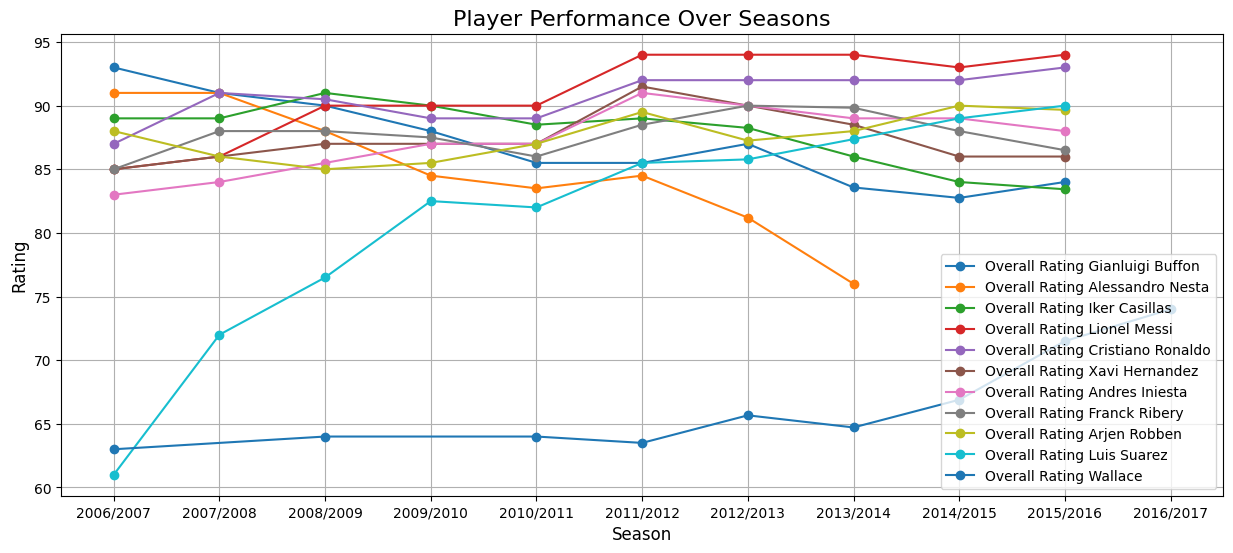

In [57]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 6))
for player in player_per_season_dict.values():
    df = players_analys[players_analys['player_name'] == player]
    plt.plot(df["season"], df["overall_rating"], marker="o", label=f"Overall Rating {player}")
plt.title(f"Player Performance Over Seasons", fontsize=16)
plt.xlabel("Season", fontsize=12)
plt.ylabel("Rating", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()



In [58]:
Player_A_merged_df

,player_api_id,season,player_name,overall_rating,potential,gk_reflexes,gk_diving,standing_tackle,interceptions,finishing,positioning,player_type
0,505942,2006/2007,Aaron Appindangoye,61.0,65.0,7.0,5.0,63.0,40.0,43.0,44.0,defensive_player
138631,39423,2006/2007,Paolo Hernan Dellafiore,70.0,71.0,6.0,13.0,69.0,73.0,50.0,46.0,defensive_player
32036,363359,2006/2007,Corentin Jean,55.0,74.0,14.0,11.0,12.0,11.0,50.0,62.0,offensive_player
138657,116907,2006/2007,Paolo Hurtado,68.0,73.0,8.0,6.0,37.0,46.0,66.0,68.0,unknown
138681,643570,2006/2007,Paolo Lemos,63.0,77.0,13.0,10.0,68.0,60.0,24.0,25.0,defensive_player
...,...,...,...,...,...,...,...,...,...,...,...,...
19709,210065,2016/2017,Bebe,72.0,75.0,11.0,15.0,24.0,24.0,67.0,67.0,unknown
1342,495841,2016/2017,Adalberto Penaranda,72.0,84.0,6.0,6.0,20.0,20.0,78.0,69.0,unknown
81814,423024,2016/2017,Jhon Murillo,67.0,79.0,12.0,7.0,18.0,17.0,64.0,61.0,unknown
95630,307224,2016/2017,Kevin Koubemba,64.0,68.0,12.0,12.0,22.0,22.0,63.0,66.0,unknown


In [59]:
defensive = Player_A_merged_df[Player_A_merged_df['player_type'] == 'defensive_player']
defensive.drop(columns=['player_api_id', 'player_type'], inplace=True)
defensive = defensive.groupby(['season', 'player_name'])[['overall_rating', 'potential', 'gk_reflexes', 
                                                         'gk_diving', 'standing_tackle', 'interceptions', 
                                                         'finishing', 'positioning']].mean().reset_index()
defensive = defensive.sort_values(by=['season', 'overall_rating'], ascending=[True, False])

offensive = Player_A_merged_df[Player_A_merged_df['player_type']=='offensive_player']
offensive.drop(columns=['player_api_id', 'player_type'], inplace=True)
offensive = offensive.groupby(['season', 'player_name'])[['overall_rating', 'potential', 'gk_reflexes', 
                                                         'gk_diving', 'standing_tackle', 'interceptions', 
                                                         'finishing', 'positioning']].mean().reset_index()
offensive = offensive.sort_values(by=['season', 'overall_rating'], ascending=[True, False])

goalkeeper = Player_A_merged_df[Player_A_merged_df['player_type']=='goalkeeper']
goalkeeper.drop(columns=['player_api_id', 'player_type'], inplace=True)
goalkeeper = goalkeeper.groupby(['season', 'player_name'])[['overall_rating', 'potential', 'gk_reflexes', 
                                                         'gk_diving', 'standing_tackle', 'interceptions', 
                                                         'finishing', 'positioning']].mean().reset_index()
goalkeeper = goalkeeper.sort_values(by=['season', 'overall_rating'], ascending=[True, False])



/tmp/ipykernel_16752/2880512661.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defensive.drop(columns=['player_api_id', 'player_type'], inplace=True)
/tmp/ipykernel_16752/2880512661.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offensive.drop(columns=['player_api_id', 'player_type'], inplace=True)
/tmp/ipykernel_16752/2880512661.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  goalkeeper.drop(columns=['player_api_id', 'p

In [60]:
defensive_player_per_season_dict = create_player_per_season_dict(defensive)
offensive_player_per_season_dict = create_player_per_season_dict(offensive)
goalkeeper_player_per_season_dict = create_player_per_season_dict(goalkeeper)


In [61]:
offensive

,season,player_name,overall_rating,potential,gk_reflexes,gk_diving,standing_tackle,interceptions,finishing,positioning
60,2006/2007,Alessandro Nesta,91.000000,92.000000,12.0,7.0,95.000000,92.000000,24.0,89.0
606,2006/2007,Fabio Cannavaro,91.000000,92.000000,11.0,5.0,93.000000,84.000000,17.0,85.0
1000,2006/2007,John Terry,91.000000,90.000000,12.0,7.0,95.000000,86.000000,16.0,91.0
2135,2006/2007,Ze Roberto,90.000000,90.000000,12.0,12.0,49.000000,85.000000,42.0,91.0
277,2006/2007,Carles Puyol,89.000000,90.000000,12.0,10.0,91.000000,89.000000,41.0,92.0
...,...,...,...,...,...,...,...,...,...,...
13565,2015/2016,Diego Ciccone,57.000000,57.000000,1.0,1.0,50.000000,61.000000,49.0,61.0
13910,2015/2016,Krzysztof Danielewicz,57.000000,62.000000,11.0,8.0,58.000000,45.000000,57.0,62.0
14345,2015/2016,Simone Grippo,57.000000,59.333333,8.0,13.0,51.000000,50.000000,48.0,65.0
14218,2015/2016,Rafal Pietrzak,53.666667,58.333333,11.0,10.0,49.333333,45.333333,40.0,63.0


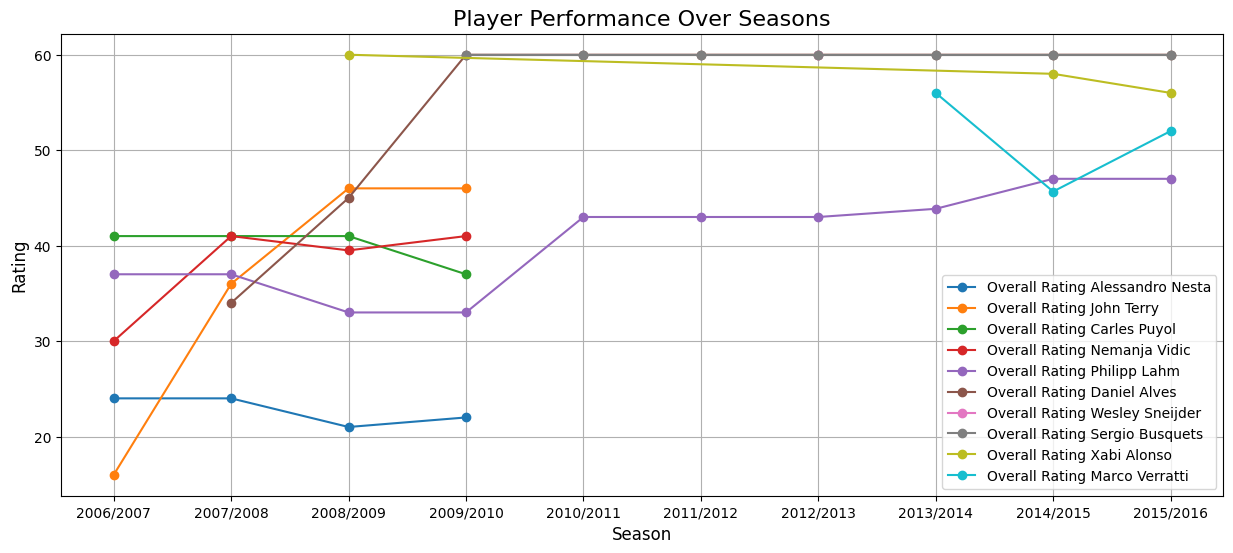

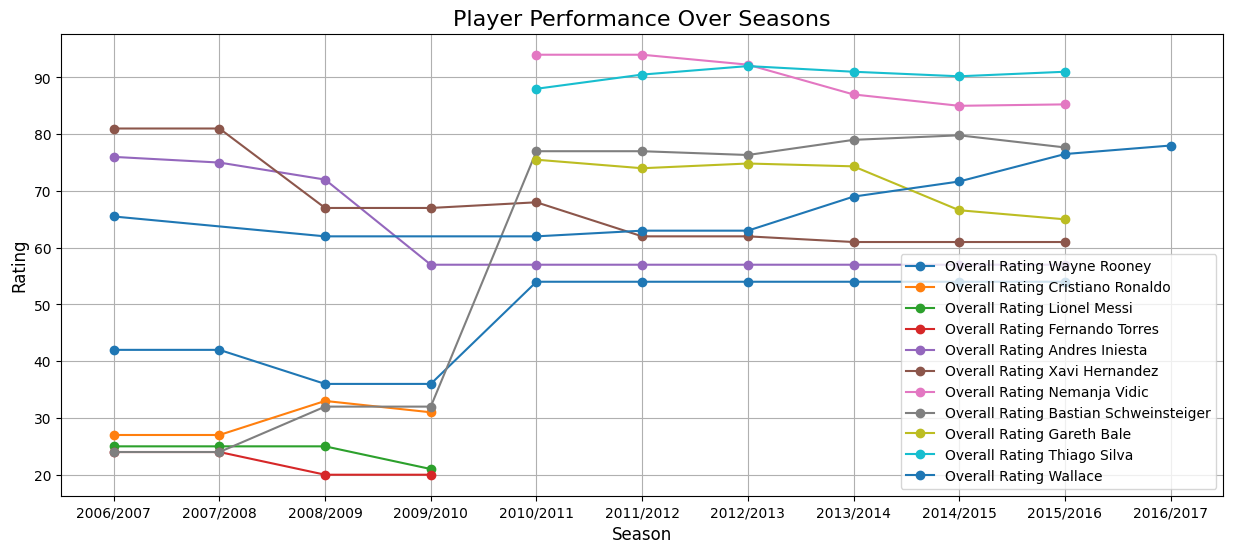

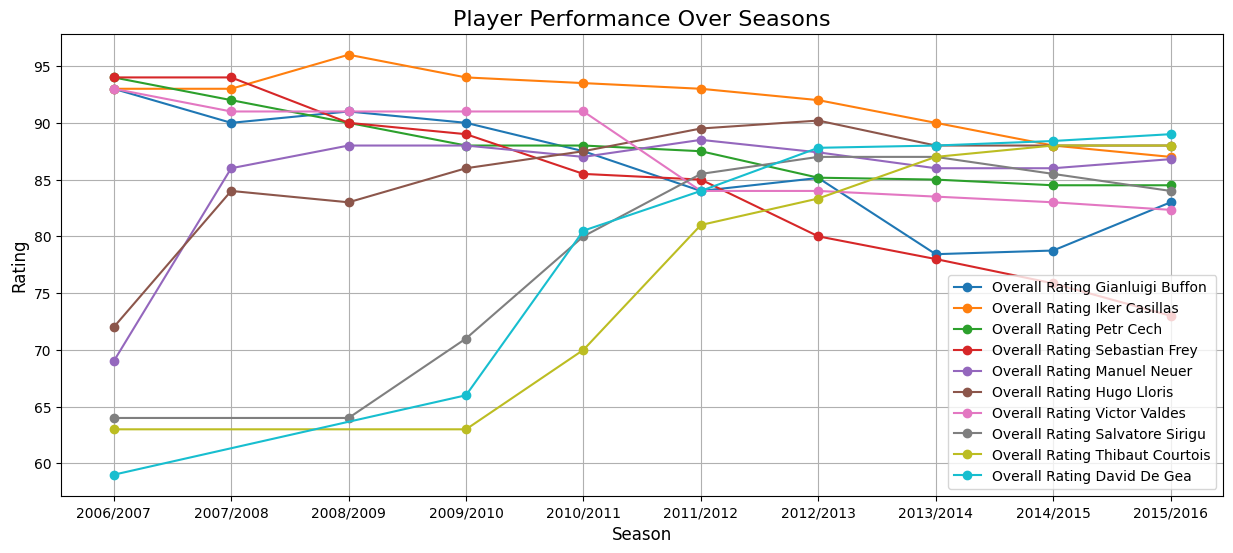

In [62]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 6))
for player in offensive_player_per_season_dict.values():
    df = offensive[offensive['player_name'] == player]
    plt.plot(df["season"], df["finishing"], marker="o", label=f"Overall Rating {player}")
plt.title(f"Player Performance Over Seasons", fontsize=16)
plt.xlabel("Season", fontsize=12)
plt.ylabel("Rating", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(15, 6))
for player in defensive_player_per_season_dict.values():
    df = defensive[defensive['player_name'] == player]
    plt.plot(df["season"], df["standing_tackle"], marker="o", label=f"Overall Rating {player}")
plt.title(f"Player Performance Over Seasons", fontsize=16)
plt.xlabel("Season", fontsize=12)
plt.ylabel("Rating", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(15, 6))
for player in goalkeeper_player_per_season_dict.values():
    df = goalkeeper[goalkeeper['player_name'] == player]
    plt.plot(df["season"], df["gk_reflexes"], marker="o", label=f"Overall Rating {player}")
plt.title(f"Player Performance Over Seasons", fontsize=16)
plt.xlabel("Season", fontsize=12)
plt.ylabel("Rating", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

Clustering : players

In [63]:
analys_player = Player_A_merged_df
analys_player.drop(columns=['player_type','season','player_api_id'], inplace=True)


In [64]:
analys_player = analys_player.groupby('player_name')[['gk_reflexes','gk_diving','standing_tackle','interceptions','finishing','positioning']].mean().reset_index()

In [65]:
analys_player[analys_player['player_name']=='Aaron Appindangoye']

,player_name,gk_reflexes,gk_diving,standing_tackle,interceptions,finishing,positioning
0,Aaron Appindangoye,7.6,5.6,66.0,52.2,43.6,44.6


In [66]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, BayesianRidge, ElasticNet, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor









columns_to_normalize = ['gk_reflexes', 'gk_diving', 'standing_tackle', 'interceptions',
                       'finishing', 'positioning']

scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(analys_player[columns_to_normalize])

normalized_table = pd.DataFrame(normalized_data, columns=columns_to_normalize)
normalized_table

,gk_reflexes,gk_diving,standing_tackle,interceptions,finishing,positioning
0,0.049481,0.051765,0.712589,0.537427,0.442504,0.455157
1,0.110022,0.125831,0.745699,0.603845,0.509620,0.532341
2,0.116760,0.146724,0.179518,0.479757,0.606702,0.648068
3,0.078832,0.148249,0.767841,0.646962,0.243731,0.357770
4,0.098743,0.081923,0.831829,0.825614,0.387937,0.404484
...,...,...,...,...,...,...
10843,0.153414,0.069127,0.692229,0.725564,0.453641,0.645420
10844,0.190882,0.146292,0.798694,0.771930,0.435626,0.588565
10845,0.099655,0.090026,0.299287,0.502339,0.774956,0.809417
10846,0.151604,0.113782,0.704671,0.676738,0.591025,0.650224


In [67]:
Player_Attributes_df

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183973,183974,102359,39902,2009-08-30 00:00:00,83.0,85.0,right,medium,low,84.0,...,88.0,83.0,22.0,31.0,30.0,9.0,20.0,84.0,20.0,20.0
183974,183975,102359,39902,2009-02-22 00:00:00,78.0,80.0,right,medium,low,74.0,...,88.0,70.0,32.0,31.0,30.0,9.0,20.0,73.0,20.0,20.0
183975,183976,102359,39902,2008-08-30 00:00:00,77.0,80.0,right,medium,low,74.0,...,88.0,70.0,32.0,31.0,30.0,9.0,20.0,73.0,20.0,20.0
183976,183977,102359,39902,2007-08-30 00:00:00,78.0,81.0,right,medium,low,74.0,...,88.0,53.0,28.0,32.0,30.0,9.0,20.0,73.0,20.0,20.0


In [68]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [69]:
kmeans = KMeans(n_clusters=3, random_state=42)
analys_player['cluster_kmeans'] = kmeans.fit_predict(normalized_data)

In [70]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(normalized_data)

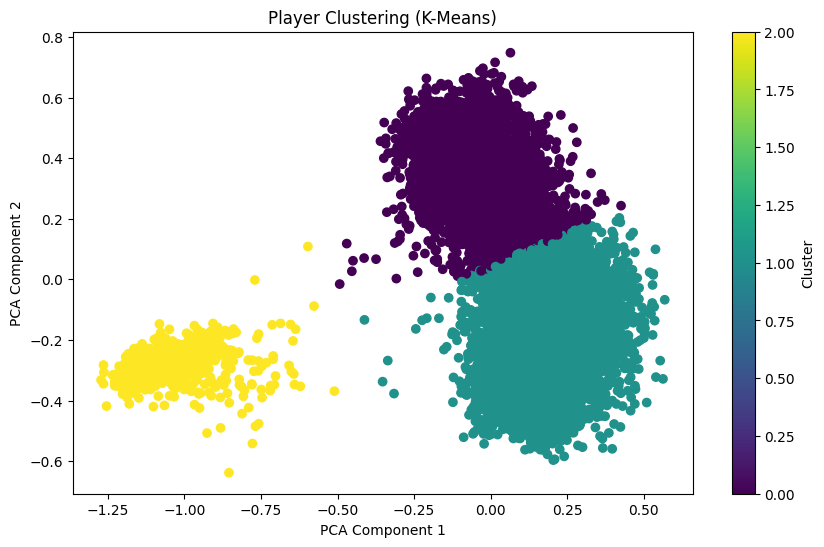

In [71]:
plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=analys_player['cluster_kmeans'], cmap='viridis')
plt.title('Player Clustering (K-Means)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [72]:
cluster_means = analys_player.groupby('cluster_kmeans')[columns_to_normalize].mean()
cluster_means

,gk_reflexes,gk_diving,standing_tackle,interceptions,finishing,positioning
cluster_kmeans,,,,,,
0,11.904357,9.911554,32.170099,37.838391,64.647365,64.961567
1,12.190471,9.843632,65.960500,63.874562,41.105300,51.599674
2,69.264056,67.864796,19.443144,27.970687,18.452606,21.398794


In [73]:
from sklearn.metrics import silhouette_score
# sampled_data = normalized_data.sample(frac=0.1, random_state=42)
# silhouette_avg = silhouette_score(sampled_data, analys_player['cluster_kmeans'])

silhouette_avg = silhouette_score(normalized_data, analys_player['cluster_kmeans'])
print(f"Silhouette Score: {silhouette_avg}")


Silhouette Score: 0.5104947942030533


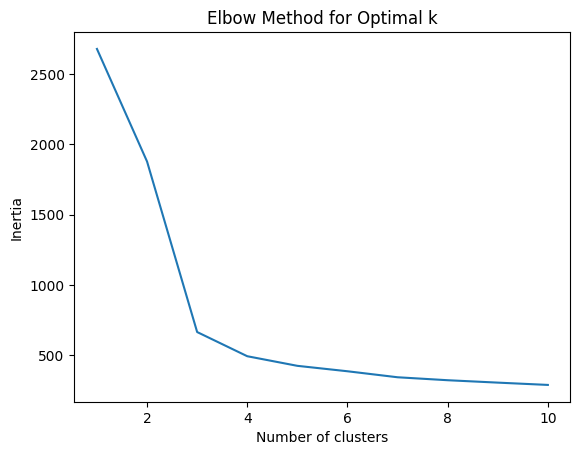

In [74]:
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(normalized_data)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia)
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()


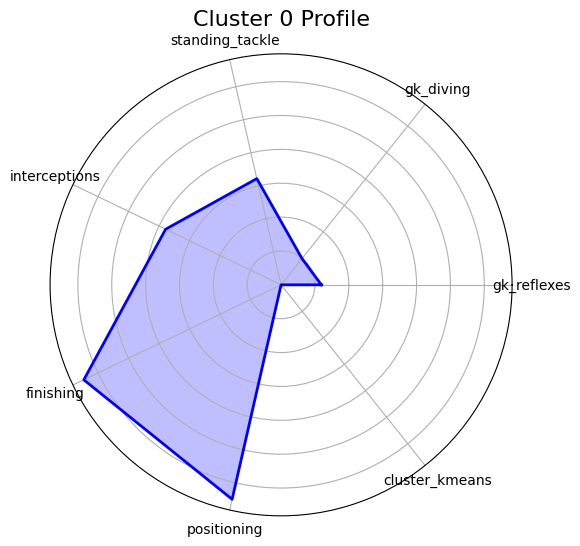

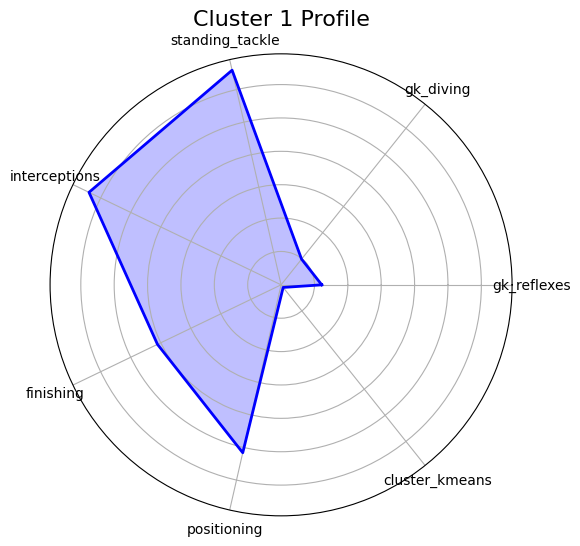

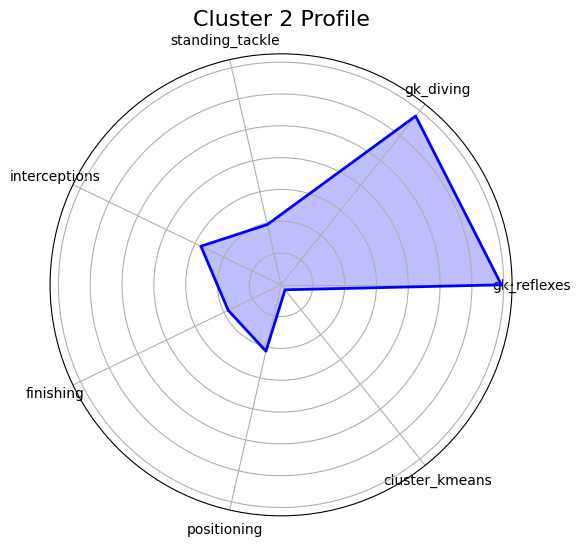

In [75]:
import numpy as np
import matplotlib.pyplot as plt

def radar_chart(cluster_data, cluster_name):
    numeric_data = cluster_data.select_dtypes(include=[np.number])
    
    values = numeric_data.mean(axis=0).values
    
    categories = numeric_data.columns  
    N = len(categories)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()

    values = np.concatenate((values, [values[0]]))
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.fill(angles, values, color='blue', alpha=0.25)
    ax.plot(angles, values, color='blue', linewidth=2)
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, rotation=45)
    ax.set_title(f'Cluster {cluster_name} Profile', fontsize=16)
    plt.show()

for cluster in range(3):  # Assuming you have 3 clusters
    cluster_data = analys_player[analys_player['cluster_kmeans'] == cluster]
    radar_chart(cluster_data, cluster)













# import numpy as np
# import matplotlib.pyplot as plt

# def radar_chart(cluster_data, cluster_name):
#     categories = columns_to_normalize  
#     values = cluster_data.mean(axis=0).values  
#     N = len(categories)
#     angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()

#     values = np.concatenate((values, [values[0]]))
#     angles += angles[:1]

#     fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
#     ax.fill(angles, values, color='blue', alpha=0.25)
#     ax.plot(angles, values, color='blue', linewidth=2)
#     ax.set_yticklabels([])
#     ax.set_xticks(angles[:-1])
#     ax.set_xticklabels(categories, rotation=45)
#     ax.set_title(f'Cluster {cluster_name} Profile', fontsize=16)
#     plt.show()

# for cluster in range(3): 
#     cluster_data = analys_player[analys_player['cluster_kmeans'] == cluster]
#     radar_chart(cluster_data, cluster)


In [76]:
for cluster in range(3):  
    cluster_players = analys_player[analys_player['cluster_kmeans'] == cluster]
    print(f"Cluster {cluster} Players:")
    display(cluster_players[['player_name']])
    print("\n")


Cluster 0 Players:


,player_name
2,Aaron Doran
5,Aaron Hunt
7,Aaron Lennon
11,Aaron Mooy
13,Aaron Niguez
...,...
10836,Zoran Josipovic
10838,Zoran Tosic
10839,Zouhaier Dhaouadhi
10845,Zvjezdan Misimovic




Cluster 1 Players:


,player_name
0,Aaron Appindangoye
1,Aaron Cresswell
3,Aaron Galindo
4,Aaron Hughes
6,Aaron Kuhl
...,...
10841,Zoumana Camara
10842,Zsolt Laczko
10843,Zsolt Low
10844,Zurab Khizanishvili




Cluster 2 Players:


,player_name
8,Aaron Lennox
41,Abdoulaye Diallo
78,Achille Coser
89,Adam Bogdan
93,Adam Collin
...,...
10779,Zacharie Boucher
10791,Zander Clark
10798,Zbigniew Malkowski
10813,Zeljko Brkic


Clustering : teams

In [77]:
team_analyse

,team_api_id,team_long_name,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
0,9987,KRC Genk,56.333333,37.657143,44.333333,55.666667,52.333333,55.833333,49.166667,50.666667,59.833333
1,9993,Beerschot AC,46.000000,30.485714,41.500000,46.000000,53.500000,53.750000,48.250000,49.000000,58.750000
2,10000,SV Zulte-Waregem,55.500000,34.323810,52.666667,50.000000,49.333333,41.500000,48.666667,56.166667,47.833333
3,9994,Sporting Lokeren,64.000000,35.323810,53.500000,44.000000,47.666667,54.333333,48.833333,55.166667,55.500000
4,9984,KSV Cercle Brugge,53.666667,36.657143,44.166667,59.000000,60.333333,48.000000,60.166667,49.666667,64.666667
...,...,...,...,...,...,...,...,...,...,...,...
283,10243,FC Zürich,56.833333,36.657143,50.000000,48.000000,55.166667,53.500000,48.666667,46.000000,55.666667
284,10190,FC St. Gallen,47.600000,36.691429,51.800000,39.800000,45.200000,44.400000,43.800000,45.600000,50.800000
285,10191,FC Thun,56.600000,41.891429,35.800000,63.200000,36.400000,59.000000,45.000000,42.800000,51.600000
286,9777,Servette FC,42.000000,30.485714,52.333333,50.333333,67.333333,50.000000,51.000000,50.000000,51.000000


In [78]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, BayesianRidge, ElasticNet, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor









columns_normalize = ['buildUpPlaySpeed','buildUpPlayDribbling','buildUpPlayPassing', 'chanceCreationPassing','chanceCreationCrossing','chanceCreationShooting','defencePressure', 'defenceAggression', 'defenceTeamWidth']

scaler = MinMaxScaler()
normalized = scaler.fit_transform(team_analyse[columns_normalize])

normalized_table = pd.DataFrame(normalized, columns=columns_normalize)
normalized_table

,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
0,0.625483,0.212907,0.304965,0.660944,0.435115,0.5750,0.530075,0.516667,0.745833
1,0.386100,0.013753,0.244681,0.412017,0.461832,0.5125,0.509398,0.475000,0.718750
2,0.606178,0.120339,0.482270,0.515021,0.366412,0.1450,0.518797,0.654167,0.445833
3,0.803089,0.148109,0.500000,0.360515,0.328244,0.5300,0.522556,0.629167,0.637500
4,0.563707,0.185136,0.301418,0.746781,0.618321,0.3400,0.778195,0.491667,0.866667
...,...,...,...,...,...,...,...,...,...
283,0.637066,0.185136,0.425532,0.463519,0.500000,0.5050,0.518797,0.400000,0.641667
284,0.423166,0.186088,0.463830,0.252361,0.271756,0.2320,0.409023,0.390000,0.520000
285,0.631660,0.330495,0.123404,0.854936,0.070229,0.6700,0.436090,0.320000,0.540000
286,0.293436,0.013753,0.475177,0.523605,0.778626,0.4000,0.571429,0.500000,0.525000


In [79]:
analys_player

,player_name,gk_reflexes,gk_diving,standing_tackle,interceptions,finishing,positioning,cluster_kmeans
0,Aaron Appindangoye,7.600000,5.600000,66.000000,52.200000,43.600000,44.600000,1
1,Aaron Cresswell,12.909091,12.181818,68.787879,57.878788,49.454545,51.484848,1
2,Aaron Doran,13.500000,14.038462,21.115385,47.269231,57.923077,61.807692,0
3,Aaron Galindo,10.173913,14.173913,70.652174,61.565217,26.260870,35.913043,1
4,Aaron Hughes,11.920000,8.280000,76.040000,76.840000,38.840000,40.080000,1
...,...,...,...,...,...,...,...,...
10843,Zsolt Low,16.714286,7.142857,64.285714,68.285714,44.571429,61.571429,1
10844,Zurab Khizanishvili,20.000000,14.000000,73.250000,72.250000,43.000000,56.500000,1
10845,Zvjezdan Misimovic,12.000000,9.000000,31.200000,49.200000,72.600000,76.200000,0
10846,de Oliveira Cleber Monteiro,16.555556,11.111111,65.333333,64.111111,56.555556,62.000000,1


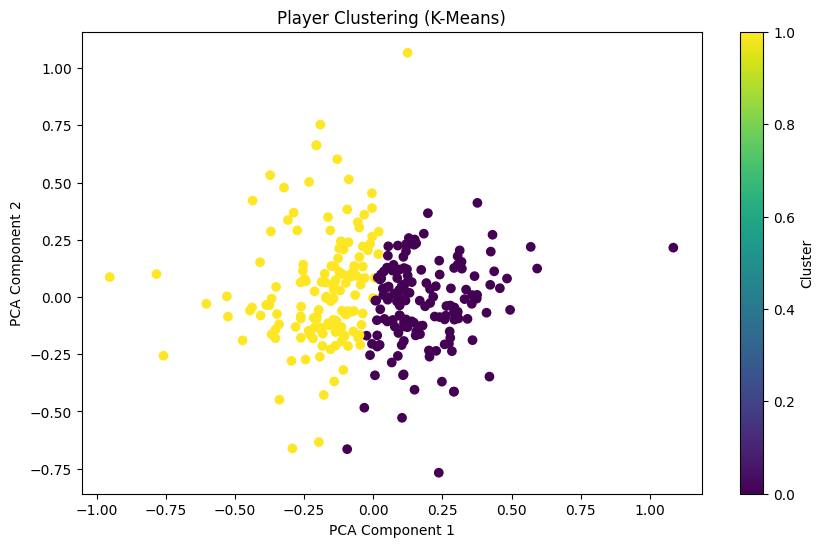

In [80]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

kmeans = KMeans(n_clusters=2, random_state=42)
team_analyse['cluster_kmeans'] = kmeans.fit_predict(normalized)
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(normalized)
plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=team_analyse['cluster_kmeans'], cmap='viridis')
plt.title('Player Clustering (K-Means)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [81]:
# normalized_table
# team_analyse

In [82]:
cluster_means_team = team_analyse.groupby('cluster_kmeans')[columns_normalize].mean()
cluster_means_team

,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
cluster_kmeans,,,,,,,,,
0,56.131179,36.383440,51.922449,55.184467,56.837415,54.744898,48.050567,50.981179,53.989116
1,47.747281,37.128018,45.391371,48.121868,49.819976,52.988534,43.496927,47.248345,50.016548


In [83]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(normalized, team_analyse['cluster_kmeans'])
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.14101505269363213


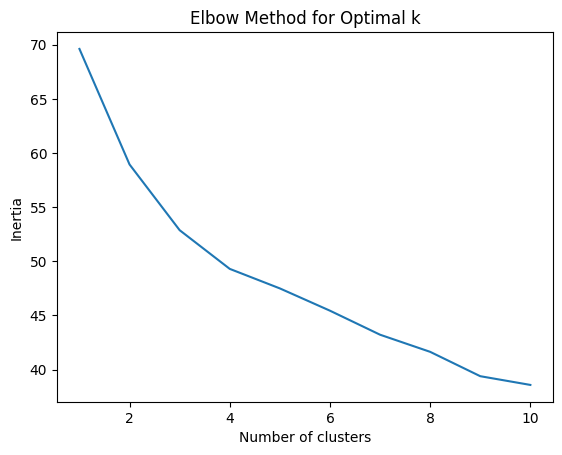

In [84]:
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(normalized)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia)
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()
